In [1]:
import torch
from utils import camera_intr
import matplotlib.pyplot as plt
import math

from utils import camera_intr, ellipse_ndim

### Data

In [2]:
mu = torch.tensor([
    [1., 1., 30.],
    [0.4, 0.4, 31.],
])

cov = torch.tensor([
    [[1., .9, 0.],
     [.9, 1.,  0.],
     [0., 0., 3.]],
    [[1., -.9, 0.],
     [-.9, 1., 0.],
     [0., 0., 3.]],
])

scale = torch.tensor([
    [1., 1., 1.],
    [1., 1., 1.],
])

quat = torch.tensor([
    [0., 0., 0., 0.],
    [0., 0., 0., 0.],
])

col = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
])

### Projection

In [3]:
def T_cw(R_cw, t_cw):
    T_cw = torch.zeros((4, 4))
    T_cw[3,3] = 1.
    T_cw[:3,:3] = R_cw[:]
    T_cw[:3,3] = t_cw

    return T_cw

def P(f_x, f_y, w, h, n, f):
    P = torch.tensor([
        [2.*f_x/w, 0., 0., 0.],
        [0., 2.*f_y/h, 0., 0.],
        [0., 0., (f+n)/(f-n), -2*f*n/(f-n)],
        [0., 0., 1., 0.],
    ])

    return P

def J(f_x, f_y, t_x, t_y, t_z):
    N = len(t_x)
    J = torch.zeros((N,2,3))
    J[:,0,0] = f_x/t_z
    J[:,1,1] = f_y/t_z
    J[:,0,2] = -f_x*t_x/t_z**2
    J[:,1,2] = -f_y*t_y/t_z**2

    return J

In [4]:
quat

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [5]:
def quat_to_rot(quaternion):
    N = quaternion.shape[0]
    x, y, z, w = quaternion[:,0],quaternion[:,1],quaternion[:,2],quaternion[:,3],

    R = torch.empty((N,3,3))
    
    R[:,0,0] = 1-2*(y**2+z**2)
    R[:,0,1] = 2*(x*y-w*z)
    R[:,0,2] = 2*(x*z+w*y)

    R[:,1,0] = 2*(x*y+w*z)
    R[:,1,1] = 1-2*(x**2-z**2)
    R[:,1,2] = 2*(y*z-w*x)

    R[:,2,0] = 2*(x*z+w*y)
    R[:,2,1] = 2*(y*z+w*x)
    R[:,2,2] = 1-2*(x**2+y**2)

    return R

In [6]:
def project_gaussians(
        mu,
        # Sigma,
        scale,
        quat,
        R_cw,
        t_cw,
        f_x,
        f_y,
        c_x,
        c_y,
        w,
        h,
        n,
        f,
    ):
    if not R_cw:
        R_cw = torch.eye(3)
    if not t_cw:
        t_cw = torch.zeros(3)

    N = mu.shape[0]

    # Project Means
    t = T_cw(R_cw, t_cw) @ torch.cat((mu.T, torch.ones(1, N))) # (4, 4) x (4, N) = (4, N)
    t_ = P(f_x, f_y, w, h, n, f) @ t # (4, 4) x (4, N) = (4, N)
    mu_ = torch.vstack((
        (w*t_[0]/t_[3]+1.)/2+c_x,
        (h*t_[1]/t_[3]+1.)/2+c_y,
    )).T
    z = t_[2]

    # Scale + Rot. to Cov.
    R = quat_to_rot(quat); S = torch.cat([torch.diag(s)[None] for s in scale])
    RS =  R @ S
    Sigma = RS @ RS.permute(0,2,1)
    print(R, S, Sigma)

    # Project Cov
    J_ = J(f_x, f_y, t[0], t[1], t[2])
    Sigma_ = J_ @ R_cw @ Sigma @ R_cw.T @ J_.permute((0,2,1))

    return mu_, z, Sigma_

In [7]:
W = H = 100.
fov_x = math.pi / 2.0
focal = 0.5 * float(W) / math.tan(0.5 * fov_x)

In [8]:
(
    mu_,
    z,
    cov_
) = project_gaussians(
    mu=mu,
    scale=scale,
    quat=quat,
    R_cw=None,
    t_cw=None,
    f_x=focal,
    f_y=focal,
    c_x=W/2,
    c_y=H/2,
    w=W,
    h=H,
    n=0.,
    f=10.
)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])


In [9]:
mu_, z, cov_

(tensor([[52.1667, 52.1667],
         [51.1452, 51.1452]]),
 tensor([30., 31.]),
 tensor([[[2.7809e+00, 3.0864e-03],
          [3.0864e-03, 2.7809e+00]],
 
         [[2.6019e+00, 4.3312e-04],
          [4.3312e-04, 2.6019e+00]]]))

In [10]:
mu_

tensor([[52.1667, 52.1667],
        [51.1452, 51.1452]])

In [11]:
cov_

tensor([[[2.7809e+00, 3.0864e-03],
         [3.0864e-03, 2.7809e+00]],

        [[2.6019e+00, 4.3312e-04],
         [4.3312e-04, 2.6019e+00]]])

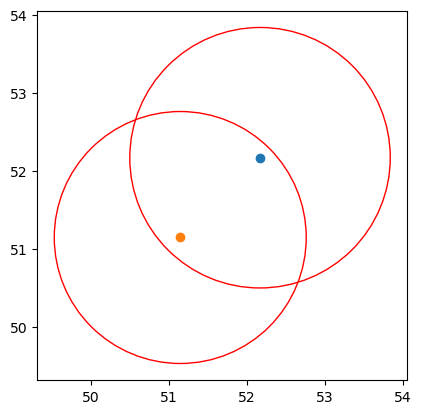

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ellipse_ndim(mu_, cov_, ax, edgecolor='red')
ax.scatter(mu_[0,0], mu_[0,1])
ax.scatter(mu_[1,0], mu_[1,1])

ax.set_aspect('equal', adjustable='box')

##################################

### Rendering

#### Evaluate Gaussians

In [13]:
def inv_2d(A):
    A_inv = torch.tensor([
        [A[1,1], -A[0,1]],
        [-A[1,0], A[0,0]],
    ])
    A_inv *= 1/(A[0,0]*A[1,1]-A[0,1]*A[1,0])

    return A_inv

In [14]:
def g(x, m, S):
    ''' x: (h*w, 2) matrix
        m: (2, 1) mean
        S: (2, 2) cov matrix
    '''
    
    x = x.T.view(-1, 1, 2)
    m = m.view(1, 1, 2)

    S_inv = inv_2d(S)
    x_m = x - m

    return torch.exp(-(1/2)*x_m @ S_inv @ x_m.permute(0,2,1))

In [15]:
x, y = torch.meshgrid(torch.linspace(47,57,1000),torch.linspace(47,57,1000), indexing='xy')
x = x.reshape(1,-1); y = y.reshape(1, -1)
x, y

(tensor([[47.0000, 47.0100, 47.0200,  ..., 56.9800, 56.9900, 57.0000]]),
 tensor([[47., 47., 47.,  ..., 57., 57., 57.]]))

In [16]:
# Sort mu_ by depth (z)
_, ind = torch.sort(z)
mu_, cov_, col = mu_[ind], cov_[ind], col[ind]

In [17]:
torch.arange(1,5), torch.prod(torch.arange(1,5))

(tensor([1, 2, 3, 4]), tensor(24))

In [18]:
F = torch.zeros(1000,1000,3)
pixels_xy = torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0)
cum_alphas = torch.ones(1,1000,1000)
for m, S, c in zip(mu_, cov_, col):
    alpha = g(pixels_xy, m, S).view(1,1000,1000)
    F += (alpha * c.view(3,1,1) * cum_alphas).permute((1,2,0)).flip(dims=(0,))
    cum_alphas *= (1 - alpha)

In [19]:
def render(x, mu_2d, cov_2d, col):
    pass

(47.0, 57.0)

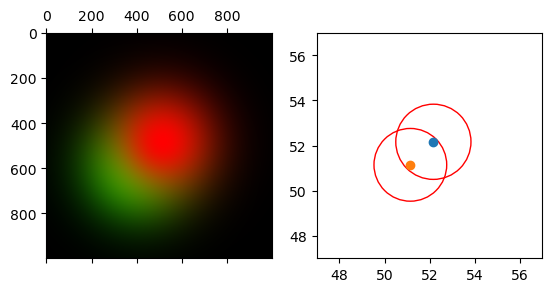

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(F)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.scatter(mu_[0,0], mu_[0,1])
ax2.scatter(mu_[1,0], mu_[1,1])
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([47,57])
ax2.set_ylim([47,57])

### Tiling (SAT)